#Emotion Detection With GloVe and CNN-BiLSTM

In [1]:
import re
import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Reading dataset and separating them as text and label

In [3]:
train_df = pd.read_csv("/content/train.txt", sep=";", header= None, names=["text", "label"])
test_df = pd.read_csv("/content/test.txt", sep=";", header= None, names=["text", "label"])
val_df = pd.read_csv("/content/val.txt", sep=";", header= None, names=["text", "label"])

In [4]:
train_df.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


Checking for null values in data

In [5]:
train_df.info()
print()
test_df.info()
print()
val_df.info()
print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   label   2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   label   2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB



Distriution of labels in Train and Test data

In [6]:
train_df["label"].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: label, dtype: int64

In [7]:
test_df["label"].value_counts()

joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: label, dtype: int64

A sample text from the dataset

In [8]:
sample = train_df["text"][1]
print(sample)

i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake


# Text Preprocessing
The preprocessing is done in a few steps:
* Lowercaseing the text
* Removing Numbers
* Removing Punctuations
* Removing Stopwords

In [11]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

stopwords = #your code('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
def lower_text(text):
    return text.lower()

def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'', text)

def remove_punct(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" 
    for p in punctuations:
        text = text.replace(p, f' {p} ')
    return text
    
def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in (stopwords)])
    return text

In [13]:
def clean_text(text):
    text = lower_text(text)
    text = remove_number(text)
    text = remove_punct(text)
    text = remove_stopwords(text)
    
    return text

In [14]:
train_df["clean_text"] = train_df["text"].apply(clean_text)
test_df["clean_text"] = test_df["text"].apply(clean_text)
val_df["clean_text"] = val_df["text"].apply(clean_text)

# Raw text vs Preprocessed Text

In [15]:
train_df.head()

,text,label,clean_text
0,i didnt feel humiliated,sadness,didnt feel humiliated
1,i can go from feeling so hopeless to so damned...,sadness,go feeling hopeless damned hopeful around some...
2,im grabbing a minute to post i feel greedy wrong,anger,im grabbing minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,love,ever feeling nostalgic fireplace know still pr...
4,i am feeling grouchy,anger,feeling grouchy


# Label Encoding Labels
This means replcing String objects as labels with integer values

In [16]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_df["encoded_train_label"] = label_encoder.fit_transform(train_df["label"])
val_df["encoded_val_label"] = label_encoder.transform(val_df["label"])
test_df["encoded_test_label"] = label_encoder.transform(test_df["label"])

In [17]:
train_df[['label', 'encoded_train_label']].drop_duplicates(keep='first')

,label,encoded_train_label
0,sadness,4
2,anger,0
3,love,3
6,surprise,5
7,fear,1
8,joy,2


In [18]:
x_train, x_test, y_train, y_test = train_df["clean_text"], val_df["clean_text"], train_df["encoded_train_label"], val_df["encoded_val_label"]

In [19]:
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from keras.utils import pad_sequences

from keras import layers
from keras.models import Sequential

EPOCHS= 5
act= "swish"
opt= tf.keras.optimizers.Adam(learning_rate=0.001)

# Converting texts to vectors via tokenization

In [20]:
tokenizer = #your code
tokenizer.fit_on_texts(x_train)

X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)
TEST = tokenizer.texts_to_sequences(#your code) 

vocab_size = #yourcode

# Calculating maximum length of a vector

In [21]:
lens_train = [len(i) for i in X_train]
lens_test = [len(i) for i in X_test]
lens = lens_train + lens_test

maxlen = np.max(lens)

print('Max len:', maxlen)

Max len: 35


# Zero padding every vector so that they are the same size

In [23]:
X_train = pad_sequences(#your code)
X_test = pad_sequences(#your code)
TEST = pad_sequences(#your code)

# One Hot Encoding integer labels

In [24]:
dummy_y_test = np_utils.to_categorical(y_test)
dummy_y_train = np_utils.to_categorical(y_train)

# Reading GloVe

In [25]:
def get_embedding_vectors(tokenizer, dim=300):
    embedding_index = {}
    with open('/content/drive/MyDrive/glove.840B.300d.txt','r') as f:
        for line in tqdm.tqdm(f, "Reading GloVe"):
            values = line.split()
            word = ''.join(values[:-300])
            vectors = np.asarray(values[-300:], dtype='float32')
            embedding_index[word] = vectors

    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((len(word_index)+1, dim))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            # words not found will be 0s
            embedding_matrix[i] = embedding_vector
          
    return #your code

In [26]:
embedding_matrix = get_embedding_vectors(tokenizer)

Reading GloVe: 2196018it [02:45, 13231.56it/s]


In [27]:
embedding_matrix.shape

(15065, 300)

# Defining CNN-BiLSTM model

In [29]:
embedding_dim = 300#your code

model = Sequential()
#(input_dim=your code, output_dim=your code, weights = [embedding_matrix], input_length=your code)
model.add(layers.Embedding(input_dim=, output_dim=, weights = [embedding_matrix], input_length=))
model.add(layers.Dropout(0.3)) 
model.add(layers.Conv1D(filters=#your code, kernel_size=3, activation=act)) 
model.add(layers.MaxPool1D(pool_size=3)) 
model.add(layers.Dropout(0.3))
model.add(layers.Conv1D(filters=#your code, kernel_size=3, activation=act)) 
model.add(layers.MaxPool1D(pool_size=3)) 
model.add(layers.Dropout(0.3))
model.add(layers.#your code(layers.LSTM(256, recurrent_dropout=0.3)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256,activation=act)) 
model.add(layers.Dropout(0.3)) 
model.add(layers.Dense(6, activation="softmax"))
model.compile(optimizer=opt, loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 300)           4519500   
                                                                 
 dropout (Dropout)           (None, 35, 300)           0         
                                                                 
 conv1d (Conv1D)             (None, 33, 32)            28832     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 11, 32)           0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 11, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 9, 32)             3104      
                                                        

In [30]:
checkpoint_filepath = './Checkpoint/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [31]:
history = model.fit(X_train, dummy_y_train, epochs=EPOCHS, verbose=1, validation_data=(X_test, dummy_y_test), batch_size=128, callbacks=[model_checkpoint_callback]) 
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=0)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=0)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/5
125/125 [==============================] - 35s 159ms/step - loss: 1.3646 - accuracy: 0.4651 - val_loss: 0.9149 - val_accuracy: 0.6695
Epoch 2/5
125/125 [==============================] - 7s 57ms/step - loss: 0.7921 - accuracy: 0.6968 - val_loss: 0.4869 - val_accuracy: 0.8390
Epoch 3/5
125/125 [==============================] - 6s 50ms/step - loss: 0.5192 - accuracy: 0.8134 - val_loss: 0.3469 - val_accuracy: 0.8745
Epoch 4/5
125/125 [==============================] - 6s 45ms/step - loss: 0.3812 - accuracy: 0.8641 - val_loss: 0.2758 - val_accuracy: 0.8985
Epoch 5/5
125/125 [==============================] - 7s 54ms/step - loss: 0.3010 - accuracy: 0.8964 - val_loss: 0.2511 - val_accuracy: 0.9100
Training Accuracy: 0.9531
Testing Accuracy:  0.9100


In [32]:
print(f"Best Accuracy Achieved by Model: {max(history.history['val_accuracy'])}")

Best Accuracy Achieved by Model: 0.9100000262260437


In [34]:
predict = model.predict(TEST)
predict_class = np.argmax(predict, axis=1)
predict_class = np.array(predict_class)
predict_class

63/63 [==============================] - 1s 4ms/step


array([4, 4, 4, ..., 2, 2, 1])

Performance Matrices

In [35]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_df["encoded_test_label"], predict_class)
cm


array([[252,   8,   1,   0,  12,   2],
       [ 14, 199,   0,   0,   9,   2],
       [  0,   5, 647,  33,   2,   8],
       [  1,   1,  22, 133,   1,   1],
       [ 17,   3,   7,   1, 550,   3],
       [  3,  24,   6,   2,   3,  28]])

<Axes: >

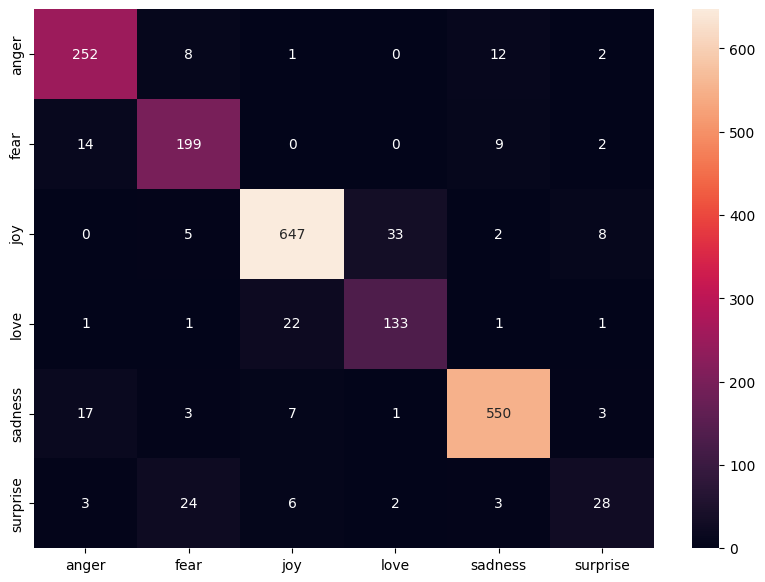

In [36]:
df_cm = pd.DataFrame(cm, index=["anger", "fear", "joy", "love", "sadness", "surprise"], columns=["anger", "fear", "joy", "love", "sadness", "surprise"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm,annot=True, fmt ="d")

In [37]:
from sklearn.metrics import classification_report

print(#your code(test_df["encoded_test_label"], predict_class, target_names =["anger", "fear", "joy", "love", "sadness", "surprise"]))


              precision    recall  f1-score   support

       anger       0.88      0.92      0.90       275
        fear       0.83      0.89      0.86       224
         joy       0.95      0.93      0.94       695
        love       0.79      0.84      0.81       159
     sadness       0.95      0.95      0.95       581
    surprise       0.64      0.42      0.51        66

    accuracy                           0.90      2000
   macro avg       0.84      0.82      0.83      2000
weighted avg       0.90      0.90      0.90      2000

